In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

In [2]:
# Random catalog
randoms = fitsio.read('/Users/roz18/Documents/Data/decals_randoms/randoms/dr3.1_5000_2v_starmasked.fits')

In [3]:
# Remove regions outside the bright star mask
ramin = [0 , 65, 115, 110, 135, 160, 253, 250, 225, 320, 325, 310]
ramax = [100, 70, 120, 114, 155, 220, 258, 255, 230, 330, 330, 330]
decmin = [-90, -6, -1.7, 17, -4, -10, 10, -2, -5, 10, 13, 10]
decmax = [-7.5, -3, 1.2, 20, -2.4, -5, 14, 2, -3, 12, 18, 15]

print(len(randoms))
mask = np.zeros(len(randoms), dtype=bool)
for index in range(len(ramin)):
    mask |= (randoms['ra']>ramin[index]) & (randoms['ra']<ramax[index]) & \
            (randoms['dec']>decmin[index]) & (randoms['dec']<decmax[index])
randoms = randoms[~mask]
print(len(randoms))

# Remove regions with inconsistent CCD data
ramin = [340, 342.4, 348.1, 352.2, 358.4, 0, 11.9]
ramax = [350, 346.5, 350.6, 355.1, 360, 4.1, 30.8]
decmin = [-6, -2.1, -2.1, -2.1, -2.1, -1.3, -2.0]
decmax = [-4, 1.7, 1.7, 1.7, 1.7, 1.3, 2.5]

print(len(randoms))
mask = np.zeros(len(randoms), dtype=bool)
for index in range(len(ramin)):
    mask |= (randoms['ra']>ramin[index]) & (randoms['ra']<ramax[index]) & \
            (randoms['dec']>decmin[index]) & (randoms['dec']<decmax[index])
randoms = randoms[~mask]
print(len(randoms))

# Remove objected contaminated by stars
print(len(randoms))
mask = randoms['star_contam']!=True
randoms = randoms[mask]
print(len(randoms))

area = len(randoms)/5000
print('Area = {:.1f} sq deg'.format(area))

8991051
7252941
7252941
6641152
6641152
6568901
Area = 1313.8 sq deg


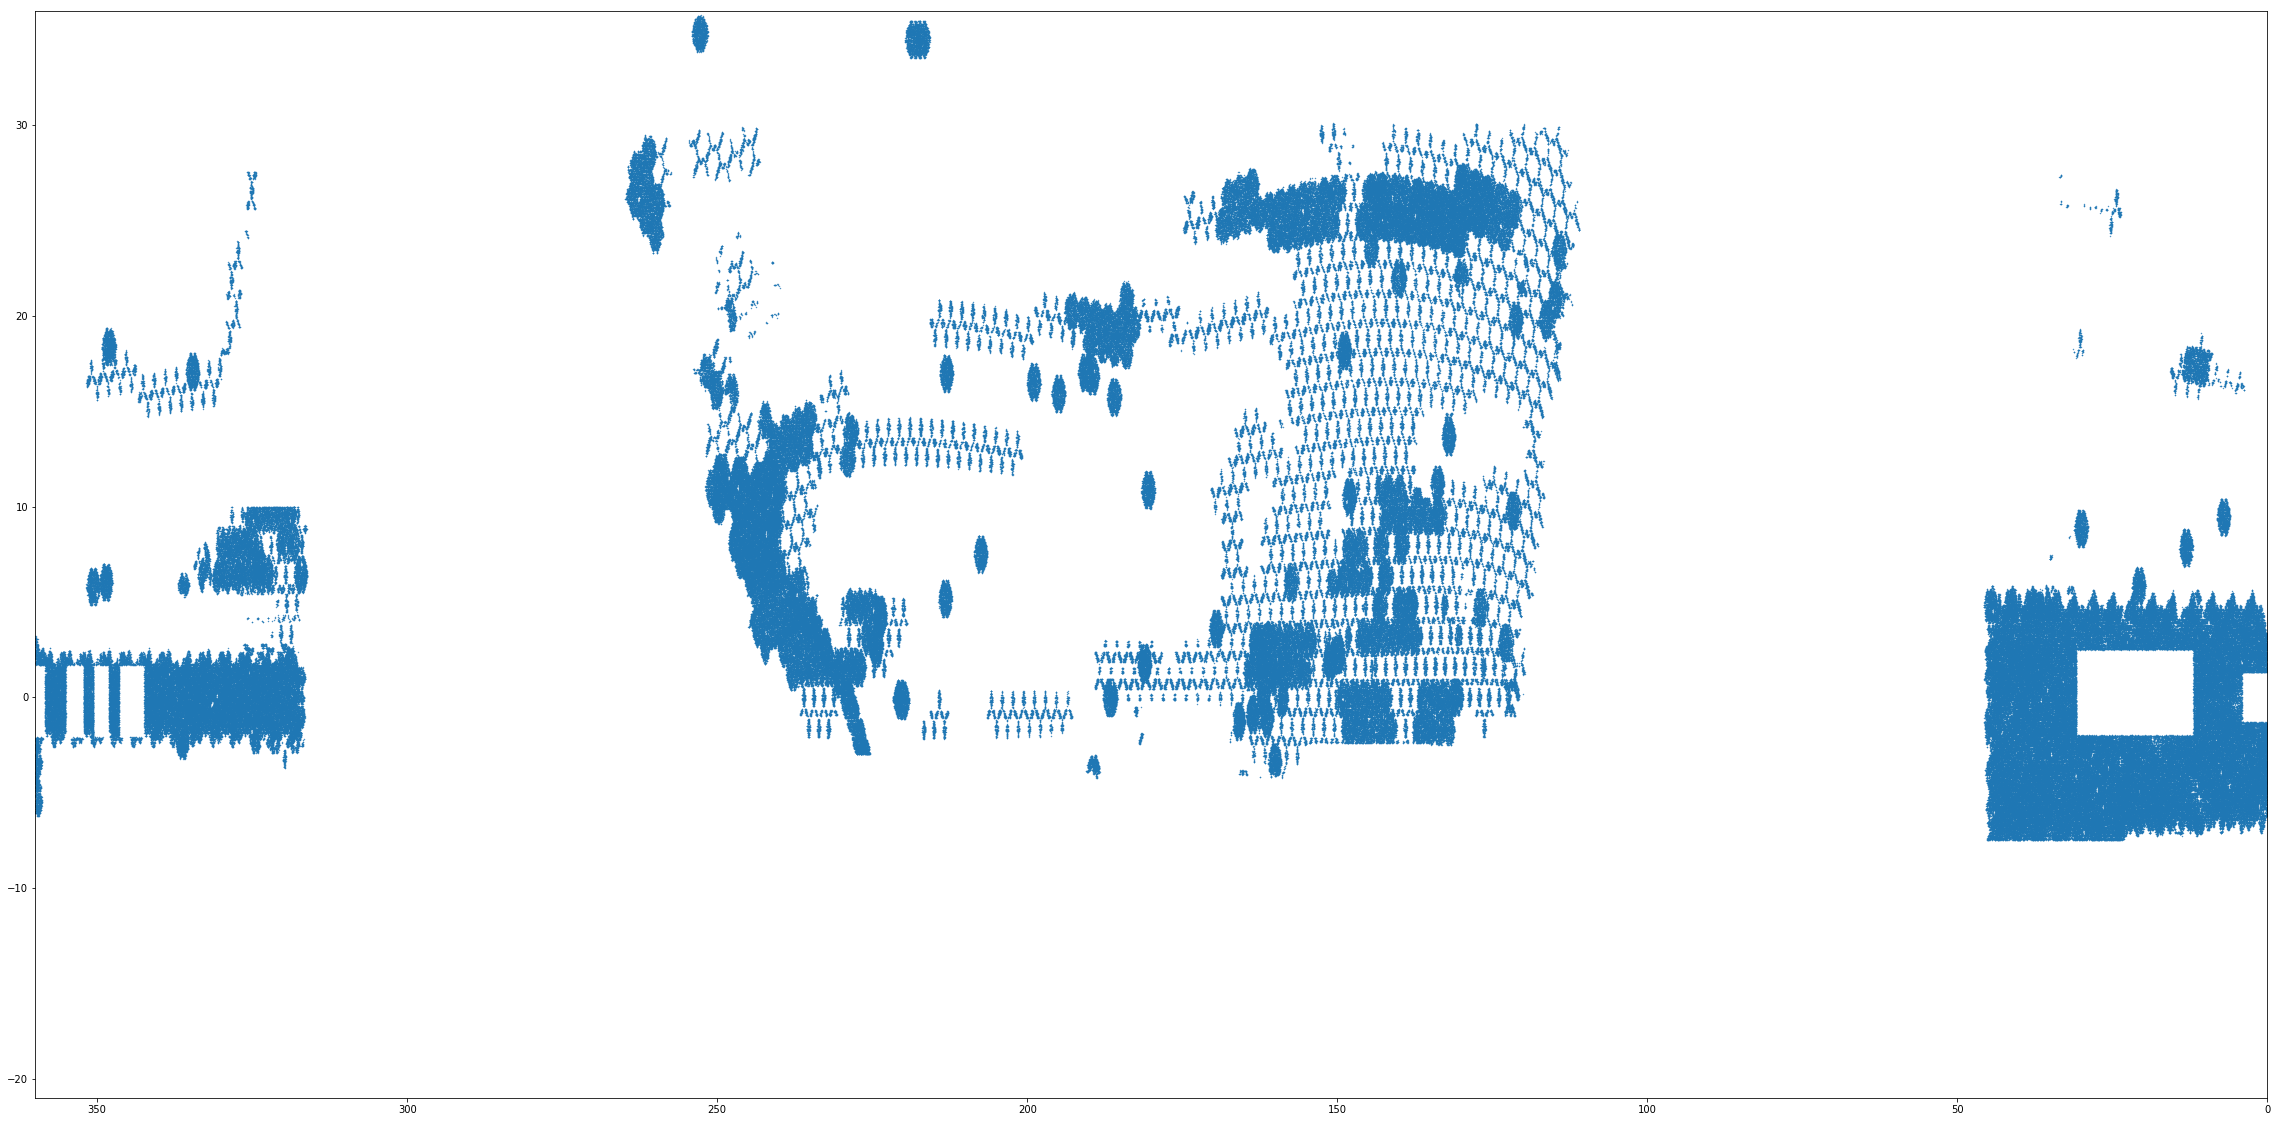

In [4]:
idx = np.random.choice(len(randoms), len(randoms)//10, replace=False)
plt.figure(figsize=(40, 20))
plt.plot(randoms['ra'][idx], randoms['dec'][idx], '.', markersize=0.8)
plt.axis([360, 0, -21, 36])
plt.show()

-------

In [5]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
# hp.pixelfunc.ang2pix
ra_array, dec_array = hp.pixelfunc.pix2ang(NSIDE, np.arange(npix), lonlat=True)

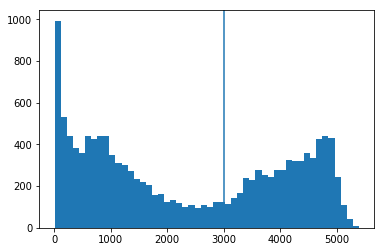

13361 occupied heapix pixels
6568900 objects


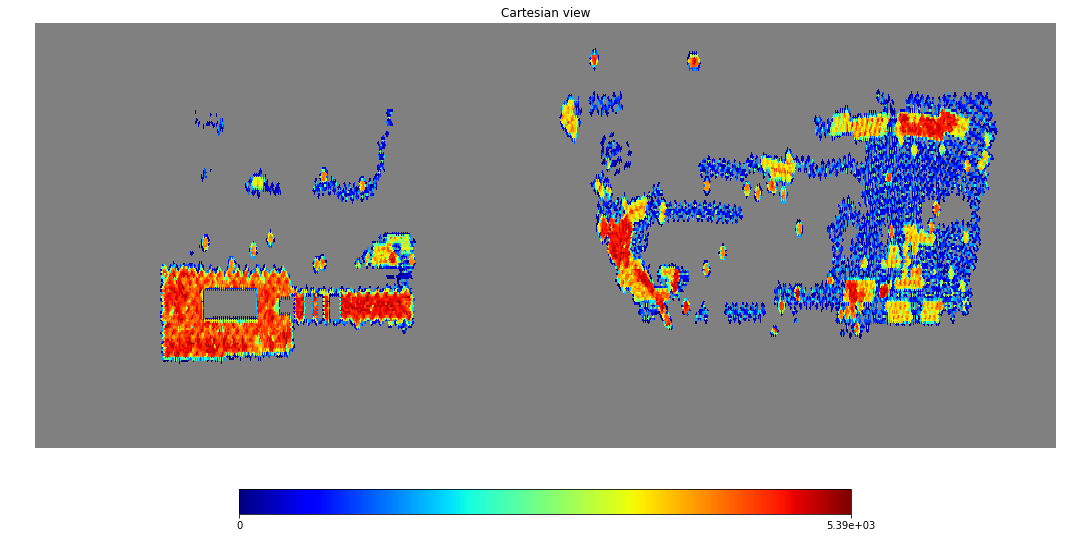

5597 occupied heapix pixels
4954513 objects (75.4%)


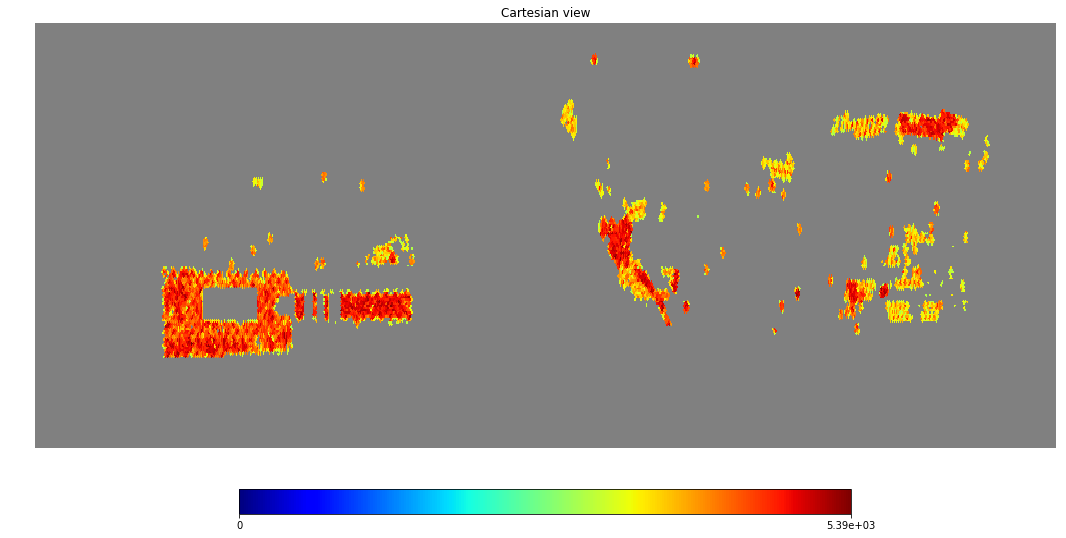

In [6]:
pix = hp.pixelfunc.ang2pix(NSIDE, randoms['ra'], randoms['dec'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m = np.zeros(npix)
m[pix_unique] = pix_count
# Convert to number density (per sq. deg.)
c = 1/(41253/npix)
m = m*c
occupied = m!=0

m_masked = hp.ma(m)
m_masked.mask = ~occupied

m_cut = 3000
plt.hist(m[occupied], 50)
plt.axvline(m_cut)
plt.show()

print(np.sum(occupied), 'occupied heapix pixels')
print(int(np.sum(m[occupied])/c), 'objects')

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

nobj0 = int(np.sum(m[occupied])/c)
occupied = m>m_cut
nobj = int(np.sum(m[occupied])/c)
m_occupied = m[occupied]

m_masked = hp.ma(m)
m_masked.mask = ~occupied

print(np.sum(occupied), 'occupied heapix pixels')
print('{} objects ({:.1f}%)'.format(nobj, nobj/nobj0*100))

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

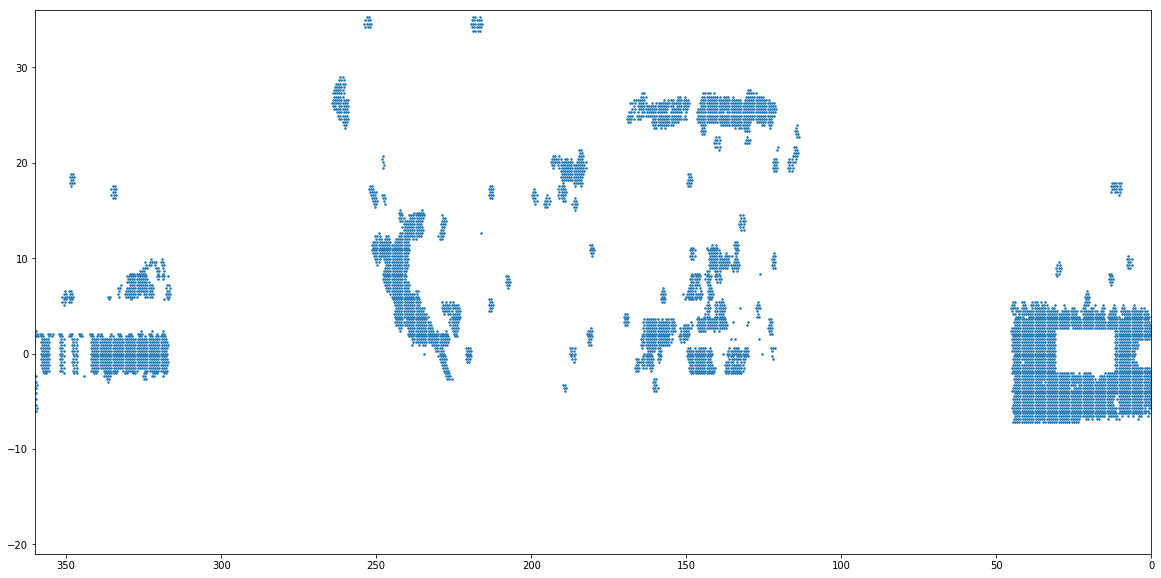

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(ra_array[occupied], dec_array[occupied], '.', markersize=3)
plt.axis([360, 0, -21, 36])
plt.show()

__Add weights to pixels by generating more pixels at the same spot__

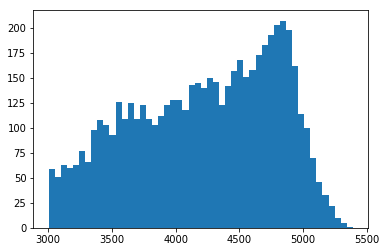

In [8]:
plt.hist(m_occupied, 50)
plt.show()

In [9]:
ra0 = ra_array[occupied]
dec0 = dec_array[occupied]

In [10]:
# Apply weights by adding more of the same pixels to the array
ra = np.copy(ra0)
dec = np.copy(dec0)
for i in range(1, 40):
    mask = np.round(m_occupied/250.)==i
    for j in range(i-1): # i-1 because there is already one copy
        ra = np.concatenate([ra, ra0[mask]])
        dec = np.concatenate([dec, dec0[mask]])

In [11]:
print(len(ra0))
print(len(ra))

5597
94472


In [13]:
coords = np.concatenate([[ra], [dec]])
coords = coords.T

__Set up default parameters__

In [14]:
n_clusters = 100

__K-means clustering:__

In [15]:
kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=50)

t0 = time.time()
kmeans.fit(coords)
elapsed_time = time.time() - t0
print('time %.2fs'%(elapsed_time))

labels = kmeans.labels_[:len(ra0)]

time 123.49s


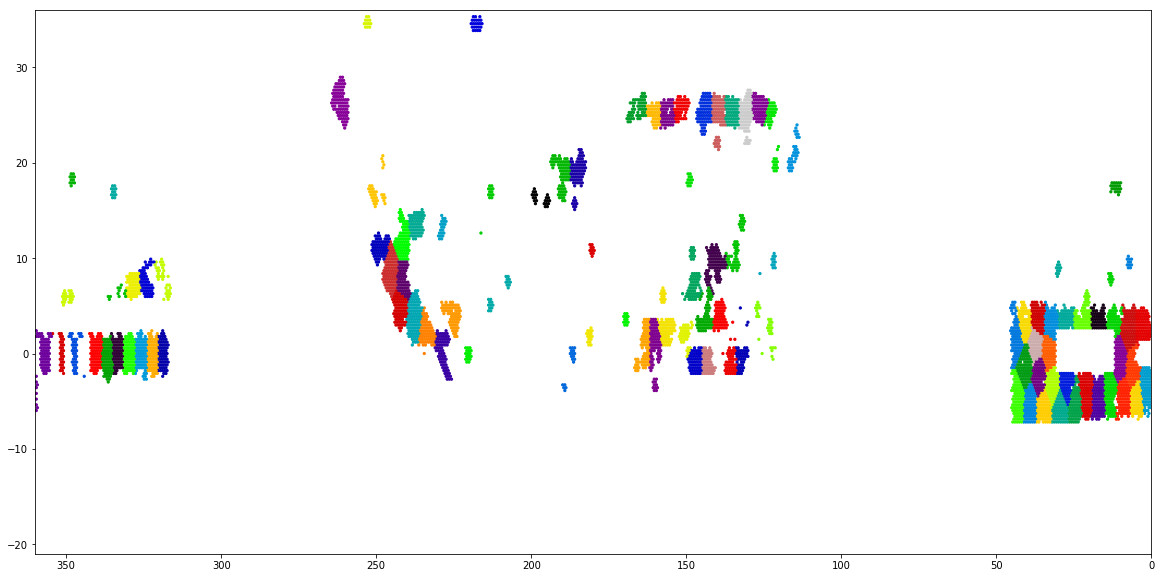

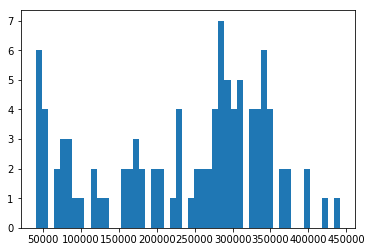

In [18]:
plt.figure(figsize=(20, 10))
plt.scatter(ra0, dec0, c=labels,
            cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.show()

counts = np.zeros(n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(labels==idx_grp)[0]
    counts[idx_grp] = np.sum(m_occupied[members])
plt.hist(counts, 50)
plt.show()

__Identify and remove outliers, and redo cluster finding:__

22 clusters discarded
6.45% objects discarded


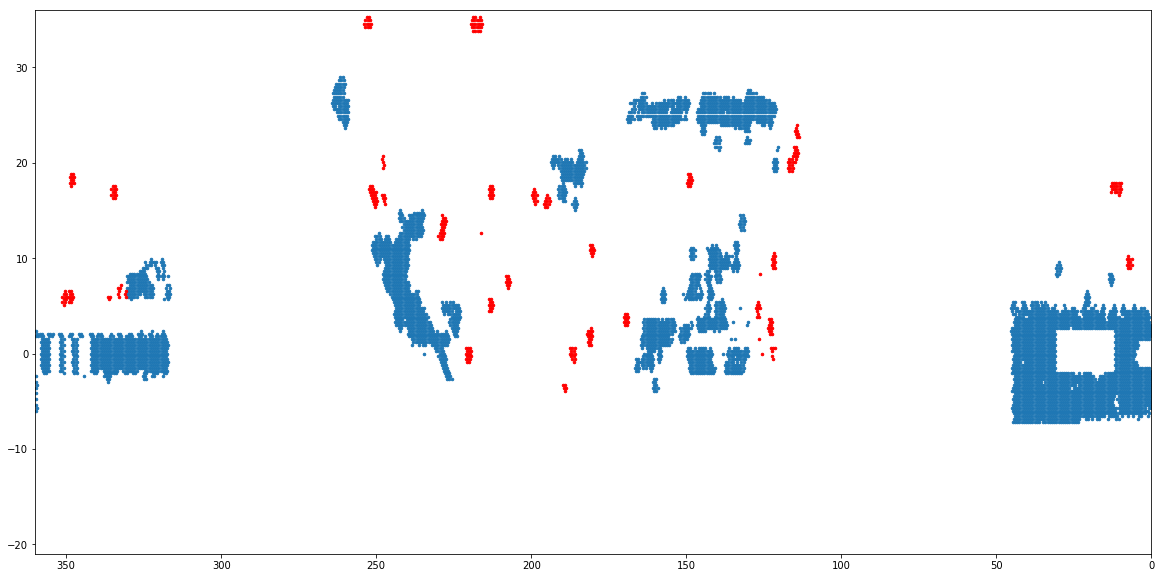

In [21]:
# mask_count = counts<150000. 
mask_count = counts<120000. 
print(np.sum(mask_count), 'clusters discarded')
pix_id_ok = np.arange(n_clusters)[mask_count]
mask_outlier = np.in1d(labels, pix_id_ok)
m_occupied1 = m_occupied[~mask_outlier]
print('{:.2f}% objects discarded'.format(100-np.sum(m_occupied1)/np.sum(m_occupied)*100))
plt.figure(figsize=(20, 10))
plt.plot(ra0[~mask_outlier], dec0[~mask_outlier], '.', markersize=5)
plt.plot(ra0[mask_outlier], dec0[mask_outlier], 'r.', markersize=5)
plt.axis([360, 0, -21, 36])
plt.show()

In [26]:
ra1 = ra0[~mask_outlier]
dec1 = dec0[~mask_outlier]

ra = np.copy(ra1)
dec = np.copy(dec1)
for i in range(1, 40):
    mask = np.round(m_occupied1/250.)==i
    for j in range(i-1): # i-1 because there is already one copy
        ra = np.concatenate([ra, ra1[mask]])
        dec = np.concatenate([dec, dec1[mask]])
        
coords = np.concatenate([[ra], [dec]])
coords = coords.T

In [28]:
print(len(ra1))
print(len(ra))

5205
88380


In [29]:
# Reduce the number of clusters
n_clusters1 = n_clusters - 22

# Redo cluster finding
kmeans1 = cluster.KMeans(n_clusters=n_clusters1, n_init=200)

t0 = time.time()
kmeans1.fit(coords)
elapsed_time = time.time() - t0
print('time %.2fs'%(elapsed_time))

labels = kmeans1.labels_[:len(ra1)]

time 319.88s


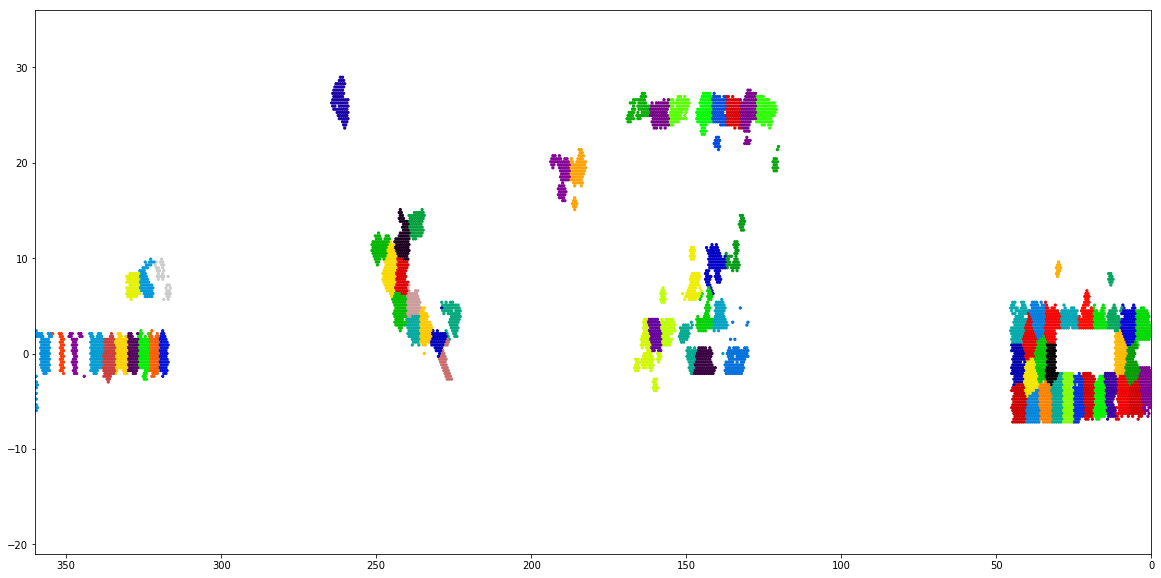

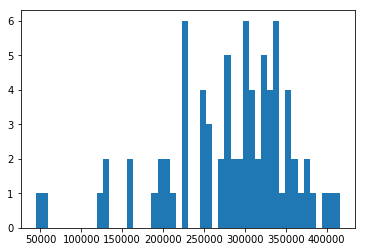

median counts = 299625.482947


In [53]:
plt.figure(figsize=(20, 10))
plt.scatter(ra1, dec1, c=labels,
            cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.show()

counts = np.zeros(n_clusters1)
for idx_grp in range(n_clusters1):
    members = np.where(labels==idx_grp)[0]
    counts[idx_grp] = np.sum(m_occupied1[members])

plt.hist(counts, 50)
plt.show()

print('median counts =', np.median(counts))

5 outlier clusters


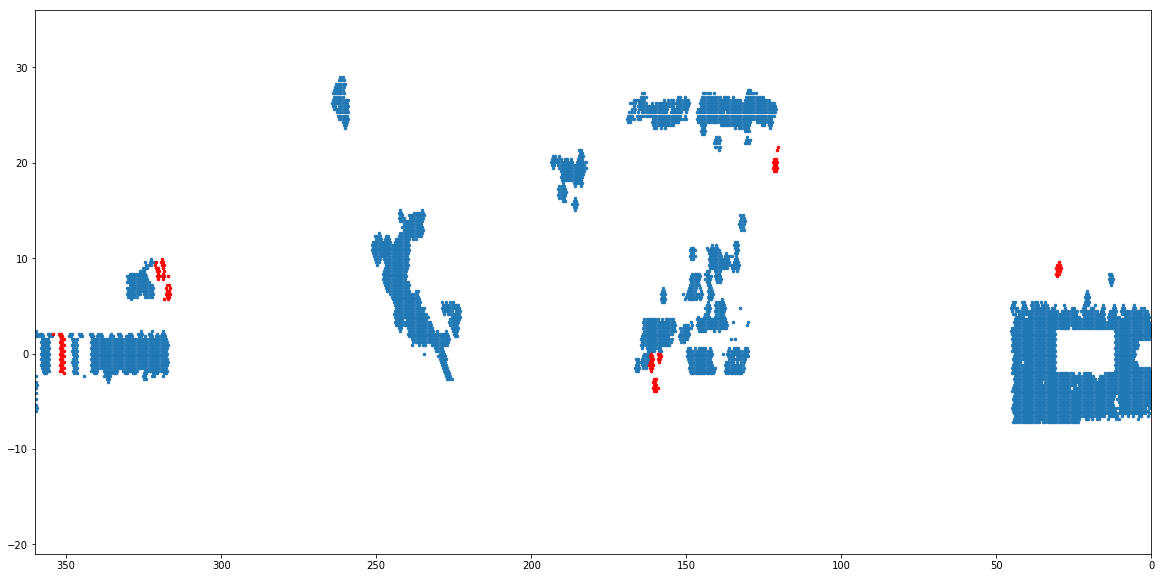

In [38]:
mask_count = counts<150000. 
print(np.sum(mask_count), 'outlier clusters')
# print('{:.2f}% objects discarded'.format(np.sum(mask_count)/len(mask_count)*100))
pix_id_ok = np.arange(n_clusters1)[mask_count]
mask_outlier = np.in1d(labels, pix_id_ok)
plt.figure(figsize=(20, 10))
plt.plot(ra1[~mask_outlier], dec1[~mask_outlier], '.', markersize=5)
plt.plot(ra1[mask_outlier], dec1[mask_outlier], 'r.', markersize=5)
plt.axis([360, 0, -21, 36])
plt.show()

__Save clustering results__

In [36]:
t = Table()
t['ra'] = ra1
t['dec'] = dec1
t['count'] = m_occupied1/c
t['density'] = m_occupied1
t['label'] = labels

t.write('/Users/roz18/git/desi-photoz/test/clustering_results.txt', format='ascii.commented_header')